In [22]:
from robot_utils.robot_data.img_data import ImgData
import matplotlib.pyplot as plt
import cv2 as cv
import math

In [17]:
bag = "/home/masonbp/data/west_point_2023/1117_03_loc_tower_loop_far_side_loop_o3_CW/align.bag"
topic = "/acl_jackal2/forward/color/image_raw/compressed"
topic_t0 = ImgData.topic_t0(bag, topic)

img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic=topic,
    time_tol=.05,
    t0=0,
    time_range=[topic_t0+200, topic_t0+220]
)

<Axes: >

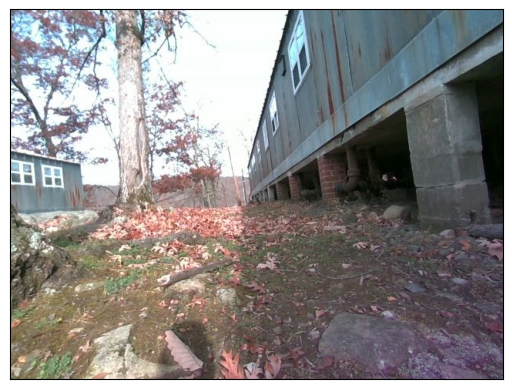

In [18]:
img_data.show(0)

In [23]:
def ssc(keypoints, num_ret_points, tolerance, cols, rows):
    exp1 = rows + cols + 2 * num_ret_points
    exp2 = (
        4 * cols
        + 4 * num_ret_points
        + 4 * rows * num_ret_points
        + rows * rows
        + cols * cols
        - 2 * rows * cols
        + 4 * rows * cols * num_ret_points
    )
    exp3 = math.sqrt(exp2)
    exp4 = num_ret_points - 1

    sol1 = -round(float(exp1 + exp3) / exp4)  # first solution
    sol2 = -round(float(exp1 - exp3) / exp4)  # second solution

    high = (
        sol1 if (sol1 > sol2) else sol2
    )  # binary search range initialization with positive solution
    low = math.floor(math.sqrt(len(keypoints) / num_ret_points))

    prev_width = -1
    selected_keypoints = []
    result_list = []
    result = []
    complete = False
    k = num_ret_points
    k_min = round(k - (k * tolerance))
    k_max = round(k + (k * tolerance))

    while not complete:
        width = low + (high - low) / 2
        if (
            width == prev_width or low > high
        ):  # needed to reassure the same radius is not repeated again
            result_list = result  # return the keypoints from the previous iteration
            break

        c = width / 2  # initializing Grid
        num_cell_cols = int(math.floor(cols / c))
        num_cell_rows = int(math.floor(rows / c))
        covered_vec = [
            [False for _ in range(num_cell_cols + 1)] for _ in range(num_cell_rows + 1)
        ]
        result = []

        for i in range(len(keypoints)):
            row = int(
                math.floor(keypoints[i].pt[1] / c)
            )  # get position of the cell current point is located at
            col = int(math.floor(keypoints[i].pt[0] / c))
            if not covered_vec[row][col]:  # if the cell is not covered
                result.append(i)
                # get range which current radius is covering
                row_min = int(
                    (row - math.floor(width / c))
                    if ((row - math.floor(width / c)) >= 0)
                    else 0
                )
                row_max = int(
                    (row + math.floor(width / c))
                    if ((row + math.floor(width / c)) <= num_cell_rows)
                    else num_cell_rows
                )
                col_min = int(
                    (col - math.floor(width / c))
                    if ((col - math.floor(width / c)) >= 0)
                    else 0
                )
                col_max = int(
                    (col + math.floor(width / c))
                    if ((col + math.floor(width / c)) <= num_cell_cols)
                    else num_cell_cols
                )
                for row_to_cover in range(row_min, row_max + 1):
                    for col_to_cover in range(col_min, col_max + 1):
                        if not covered_vec[row_to_cover][col_to_cover]:
                            # cover cells within the square bounding box with width w
                            covered_vec[row_to_cover][col_to_cover] = True

        if k_min <= len(result) <= k_max:  # solution found
            result_list = result
            complete = True
        elif len(result) < k_min:
            high = width - 1  # update binary search range
        else:
            low = width + 1
        prev_width = width

    for i in range(len(result_list)):
        selected_keypoints.append(keypoints[result_list[i]])

    return selected_keypoints

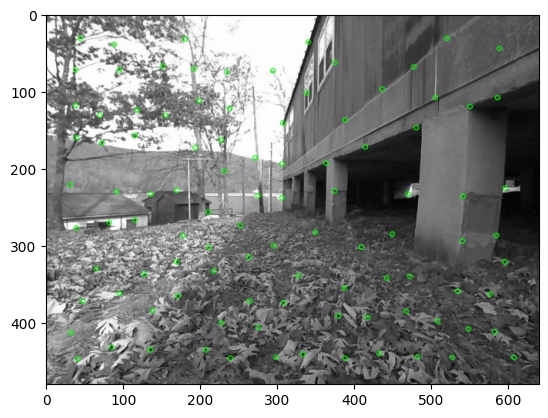

(<matplotlib.image.AxesImage at 0x7fb72d143340>, None)

In [30]:
img = img_data.img(15)

# convert to grayscale
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
# Initiate ORB detector
orb = cv.ORB_create(nfeatures=50000)
 
# find the keypoints with ORB
kp = orb.detect(img, None)
 
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# keypoints should be sorted by strength in descending order
# before feeding to SSC to work correctly
kp = sorted(kp, key=lambda x: x.response, reverse=True)

kp_sel = ssc(
    kp, 100, .1, img.shape[1], img.shape[0]
)
 
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp_sel, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()